# Лабораторная работа №5 Обучение на основе временных различий
**Цель лабораторной работы:** ознакомление с базовыми методами обучения с подкреплением на основе временных различий.

## Задание
На основе рассмотренного на лекции примера реализуйте следующие алгоритмы:

- SARSA;
- Q-обучение;
- двойное Q-обучение.

для любой среды обучения с подкреплением (кроме рассмотренной на лекции среды Toy Text / Frozen Lake) из библиотеки Gym (или аналогичной библиотеки).

## Описание среды

Возьмём из библиотеки Gym среду Taxi-v3: https://www.gymlibrary.dev/environments/toy_text/taxi/

Задача представляет собой задачу о такси из книги Тома Диттериха "Обучение с иерархическим подкреплением с помощью декомпозиции функции MAXQ Value".

На карте есть 4 определенных места, обозначенных R(ed), G(reen), Y(ellow) и B(lue). Когда начинается поездка, такси выезжает из случайного квадрата, а пассажир оказывается в случайном месте. Такси подъезжает к месту нахождения пассажира, забирает его, отвозит в пункт назначения (другое из 4 указанных мест), а затем высаживает пассажира. Как только пассажир высажен, поездка заканчивается.

Есть 500 состояний:
- карта размером 5x5;
- 4 локации;
- 5 состояний пассажира (4 выхода и в такси).

Есть 6 действий:
- 0: двигаться на юг;
- 1: двигаться на север;
- 2: двигаться на запад;
- 3: двигаться на восток;
- 4: посадить пассажира;
- 5: высадить пассажира.

Существует 400 состояний, до которых можно добраться во время поездки. Пропущенные состояния соответствуют ситуациям, в которых пассажир находится в том же месте, что и пункт назначения, поскольку это обычно сигнализирует об окончании поездки. 4 дополнительных состояния можно наблюдать сразу после успешного завершения поездки, когда и пассажир, и такси находятся в пункте назначения. Всего получается 404 доступных дискретных состояния.

Каждое пространство состояний представлено кортежем: (taxi_row, taxi_col, passenger_location, destination).

Точки посадки пассажира:
- 0: R(ed);
- 1: G(reen);
- 2: Y(ellow);
- 3: B(lue);
- 4: в такси.

Пункты назначения (пункты высадки):
- 0: R(ed);
- 1: G(reen);
- 2: Y(ellow);
- 3: B(lue).

Награды:
- -1 за каждый шаг, если не предусмотрено иное вознаграждение;
- +20 за доставку пассажира;
- -10 за некорректное выполнение действий "погрузка" и "высадка".

## Описание агентов

Импорт библиотек:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm

Базовый агент:

In [38]:
class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''

    # Наименование алгоритма
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1, color='green'):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        #и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []
        self.color = color


    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)


    def get_state(self, state):
        '''
        Возвращает правильное начальное состояние
        '''
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        return np.argmax(self.Q[state])


    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0,1) < self.eps:

            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)


    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=0.5, color=self.color, alpha=0.6)
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()


    def learn():
        '''
        Реализация алгоритма обучения
        '''
        pass

SARSA:

In [39]:
class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    # Наименование алгоритма
    ALGO_NAME = 'SARSA'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000, color='green'):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01
        self.color = color


    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state)

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Выполняем следующее действие
                next_action = self.make_action(next_state)

                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

Q-обучение:

In [40]:
class QLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Q-обучение'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000, color="green"):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01
        self.color = color


    def learn(self):
        '''
        Обучение на основе алгоритма Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                # Правило обновления Q для SARSA (для сравнения)
                # self.Q[state][action] = self.Q[state][action] + self.lr * \
                #     (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

Двойное Q-обучение:

In [41]:
class DoubleQLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Double Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Двойное Q-обучение'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000, color="green"):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros((self.nS, self.nA))
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01
        self.color = color


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)


    def print_q(self):
        print('Вывод Q-матриц для алгоритма ', self.ALGO_NAME)
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)


    def learn(self):
        '''
        Обучение на основе алгоритма Double Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * \
                        (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * \
                        (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

### Опишем функции для запуска обучения

In [42]:
def play_agent(agent):
    '''
    Проигрывание сессии для обученного агента
    '''
    env2 = gym.make('Taxi-v3', render_mode='human')
    state = env2.reset()[0]
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True

In [43]:
# запуск SARSA
def run_sarsa(color):
    env = gym.make('Taxi-v3')
    agent = SARSA_Agent(env, color=color)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)


# запуск q-обучения
def run_q_learning(color):
    env = gym.make('Taxi-v3')
    agent = QLearning_Agent(env, color=color)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)


# запуск двойного q-обучения
def run_double_q_learning(color):
    env = gym.make('Taxi-v3')
    agent = DoubleQLearning_Agent(env, color=color)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

## Обучение агентов

### SARSA:

100%|██████████| 20000/20000 [00:13<00:00, 1454.64it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -7.7579811   -2.69023113  -3.96407234  -2.93321516   8.03222758
  -10.70987293]
 [  0.75002468   6.49739021   0.78970022   5.74989389  13.0932037
   -4.45421783]
 ...
 [ -2.38328501  11.17884182  -1.30990047  -2.46884919  -6.46148885
   -7.14730879]
 [ -7.83209882  -7.73640694  -7.69907111  -0.59356821 -13.39254784
  -13.74298586]
 [  2.10716521   3.98410833   2.67266692  17.7922258   -1.00592
   -4.11721446]]


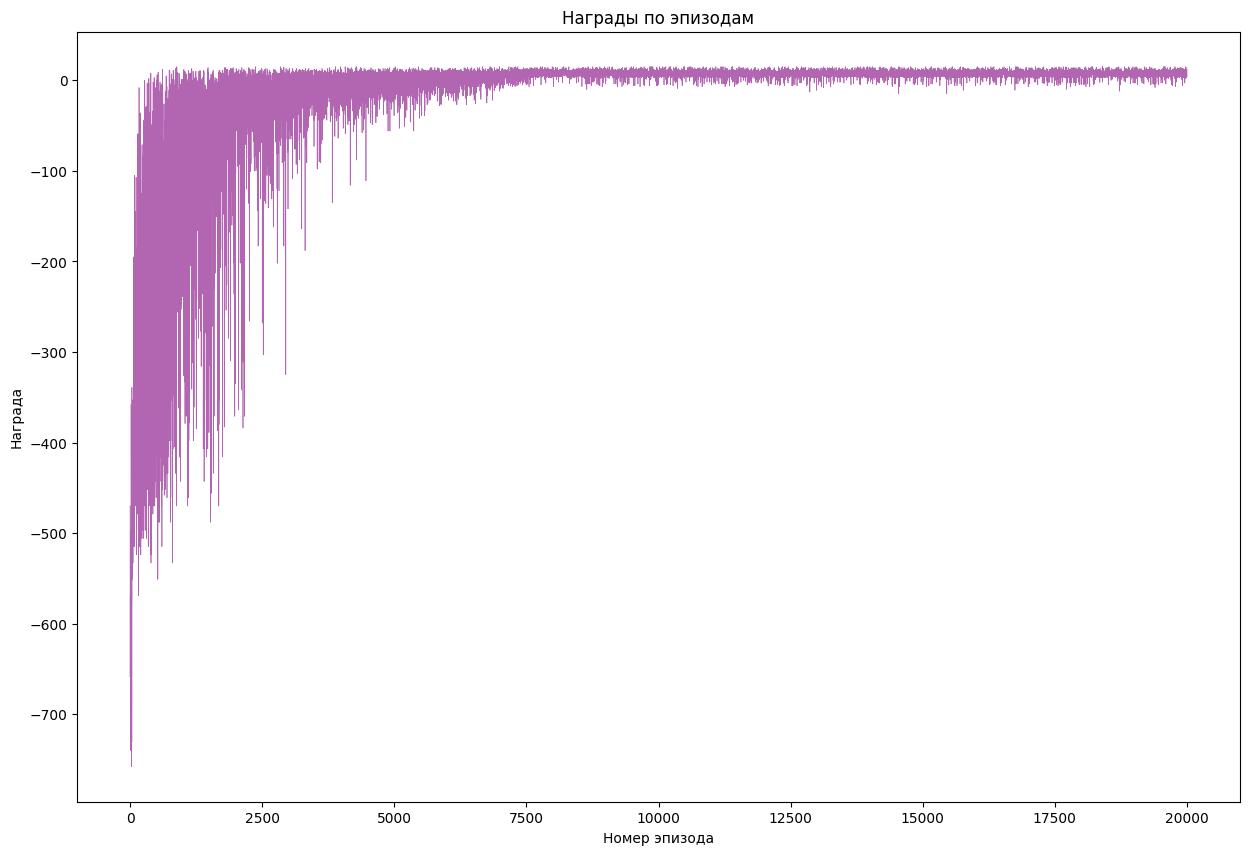

In [44]:
run_sarsa(color="purple")

#### Анализ обучения SARSA:

- **SARSA**: Это метод обучения с подкреплением, в котором агент учится принимать решения, исследуя и действуя в окружающей среде. SARSA является он-полиси методом, что означает, что он использует текущую политику для обучения и обновления своих действий.
- **Среда Taxi**: Это стандартная задача из OpenAI Gym, где агент (такси) должен перемещать пассажиров между определенными местами на сетке, избегая препятствий и минимизируя количество шагов.

**Интерпретация результатов на изображении**

1. **Начальная фаза обучения**: В начале обучения агент действовал случайным образом, и награды были очень низкими, что видно по сильным отрицательным значениям на графике.
2. **Процесс улучшения**: Со временем агент начал лучше понимать среду и улучшать свои действия, что привело к увеличению награды за итерацию (эпизод). Это видно по постепенному увеличению значений наград и уменьшению их разброса.
3. **Стабилизация**: К концу графика награды стали более стабильными, что указывает на то, что агент достиг определенного уровня мастерства в выполнении задачи и теперь получает более постоянные (и менее отрицательные) награды.

**Вывод**

Результаты на изображении показывают, что алгоритм SARSA успешно обучился в среде Taxi.

### Q-обучение:

100%|██████████| 20000/20000 [00:15<00:00, 1313.33it/s]


Вывод Q-матрицы для алгоритма  Q-обучение
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.36585472e+00  6.72060364e+00  4.53725429e+00  5.56172794e+00
   8.36234335e+00 -2.28445478e+00]
 [ 1.01427433e+01  1.08392561e+01  8.81599024e+00  1.06631620e+01
   1.32744558e+01  2.28998325e+00]
 ...
 [-7.64341525e-03  1.42290914e+01  4.16376816e-02 -1.40525991e+00
  -2.76661099e+00 -1.56203265e+00]
 [-2.72350168e+00 -4.74599812e-02 -2.68889479e+00  8.57708715e+00
  -8.58960002e+00 -7.68548900e+00]
 [ 2.87561997e+00  5.14349575e+00  4.59947896e+00  1.85993538e+01
   2.52522870e+00  2.69692250e+00]]


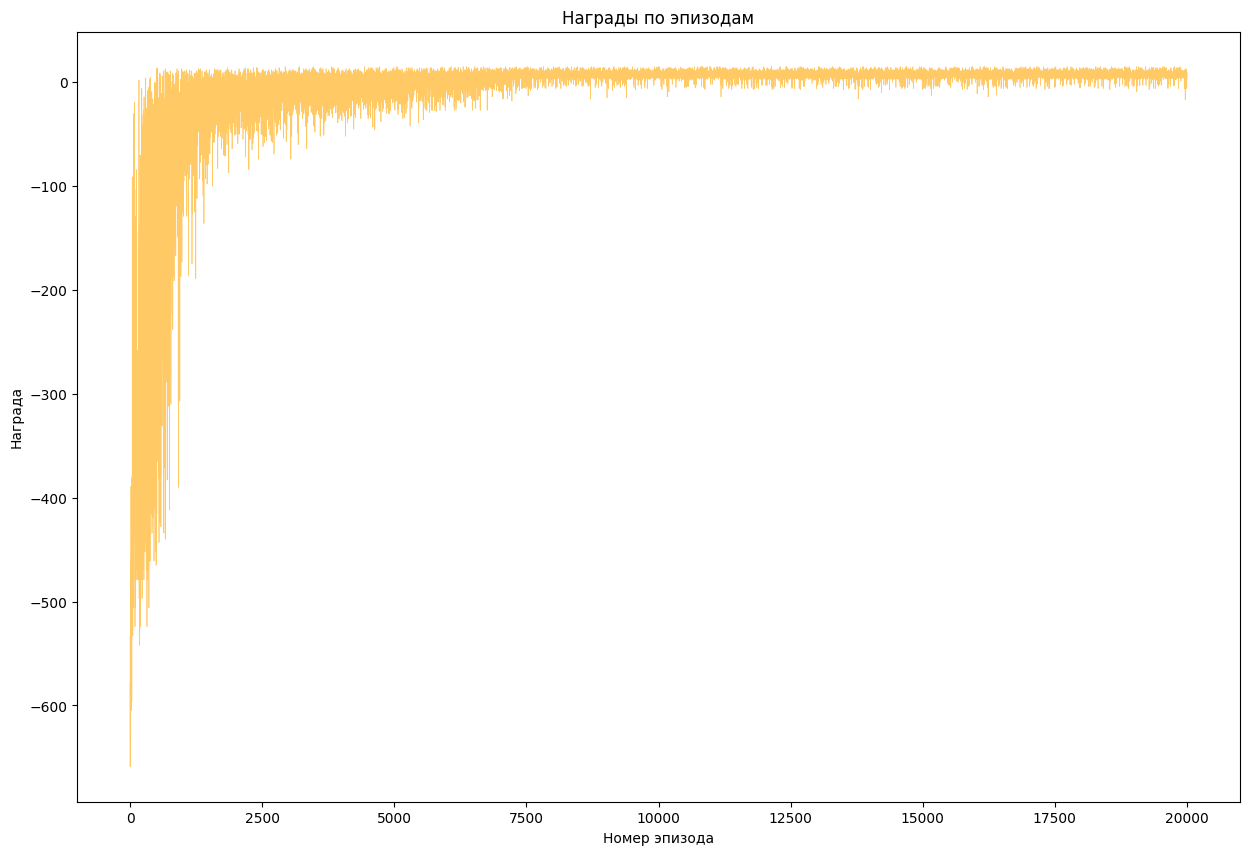

In [45]:
run_q_learning(color="orange")

#### Анализ Q-обучения:

Q-обучения позволило агенту в более короткие сроки добится высоких вознаграждений.

**Сравнение с результатами SARSA:**

1. **Начальная фаза обучения**:
   - **SARSA**: В начале обучения наблюдаются сильные отрицательные значения наград. Агент действует случайным образом, что приводит к высокому уровню неопределенности.
   - **Q-обучение**: В начальной фазе также наблюдаются значительные отрицательные значения наград, что типично для алгоритмов обучения с подкреплением.

2. **Процесс улучшения**:
   - **SARSA**: Наблюдается постепенное увеличение наград с уменьшением разброса значений по мере обучения агента. Агент постепенно улучшает свои действия и стратегию.
   - **Q-обучение**: Также наблюдается улучшение наград, однако, процесс улучшения может быть быстрее по сравнению с SARSA, так как Q-обучение является более агрессивным методом и выбирает действия с максимальной ожидаемой наградой (off-policy).

3. **Стабилизация**:
   - **SARSA**: Награды стабилизируются на уровне около 0, показывая, что агент достиг устойчивого уровня выполнения задачи.
   - **Q-обучение**: Аналогично, награды стабилизируются, но на графике видно, что значения наград становятся более плотными и менее изменчивыми, что может указывать на более оптимальное решение задачи по сравнению с SARSA.

**Вывод:**
- **Q-обучение** часто может приводить к более оптимальным решениям быстрее, чем SARSA, так как оно выбирает действия с максимальной ожидаемой наградой независимо от текущей политики.
- **SARSA** учитывает текущую политику при обучении, что может делать его более стабильным в некоторых ситуациях, но также может замедлять процесс обучения.
- Оба алгоритма достигают стабилизации наград, но Q-обучение часто приводит к более плотной и оптимизированной стратегии.


### Двойное Q-обучение:

100%|██████████| 20000/20000 [00:16<00:00, 1205.44it/s]


Вывод Q-матриц для алгоритма  Двойное Q-обучение
Q1
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.75415879   1.47992392  -2.37557357  -0.95628193   8.36234335
   -8.12339388]
 [  7.98855174   5.56425463   4.84006667   7.8454877   13.27445578
   -0.22899795]
 ...
 [  7.54539097  14.5657712    9.25528451   8.13890484  -2.64939251
   -0.79629444]
 [ -4.48564632   0.2100468   -4.6603836   -4.43622127 -11.25518983
   -7.79207894]
 [  0.28428968   2.0807276    5.58871239  18.48512597   0.66934665
    0.1069115 ]]
Q2
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 2.2818509  -0.80753056 -0.65845996 -0.91700578  8.36234335 -5.47381682]
 [ 6.97495651  8.13295492  5.52974224 10.25065312 13.27445578 -2.83215934]
 ...
 [ 7.82056394 14.5657712   6.76346001  6.35550229  1.91137336 -0.77133643]
 [-4.76818684  5.09767572 -4.68496078 -3.29404126 -8.67737512 -9.56009037]
 [ 1.46003829  1.95972501  1.45723399 18.23657497 -0.23420052 -1.0186

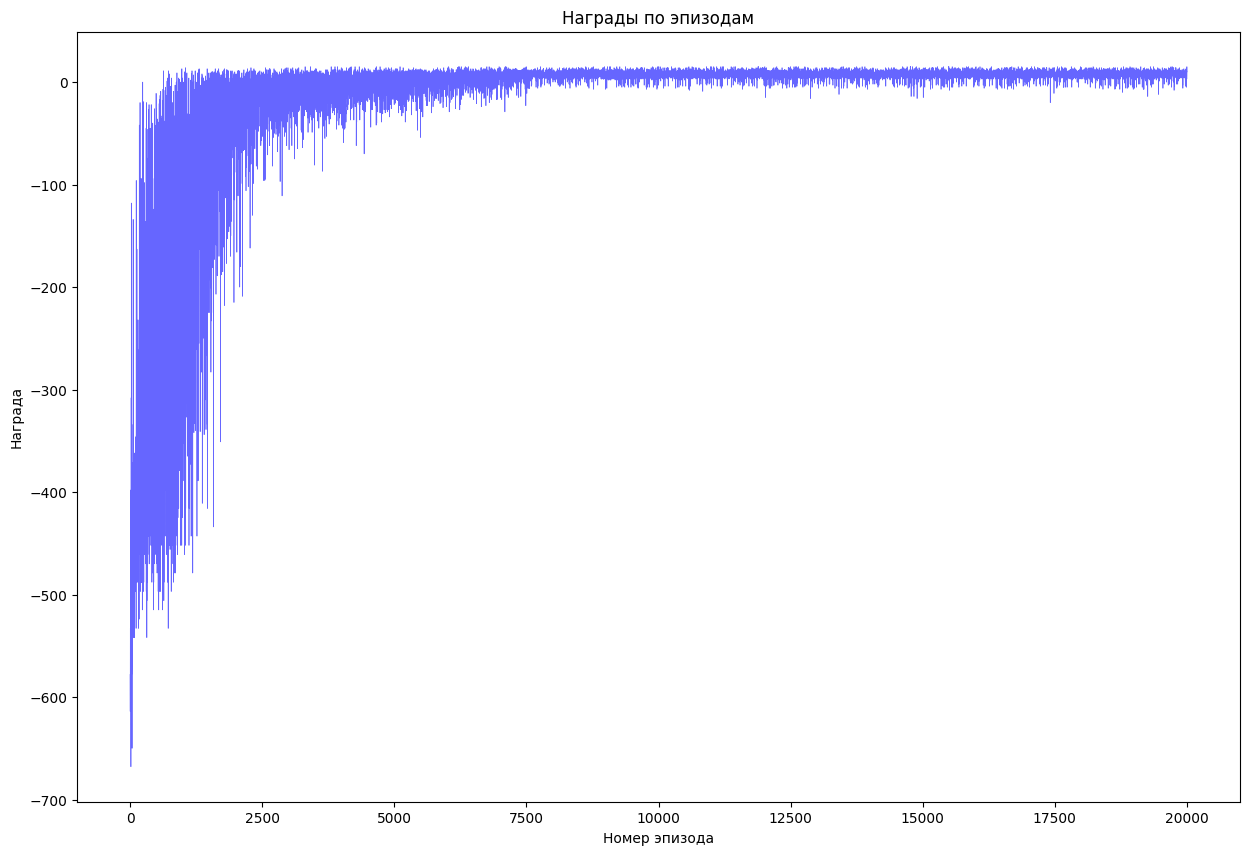

In [46]:
run_double_q_learning(color="blue")

#### Double Q-Learning: Интерпретация результатов и сравнение с SARSA и Q-Learning


**Сравнение с SARSA и Q-Learning:**
Давайте проведем сравнение результатов Double Q-Learning с результатами SARSA и Q-Learning на основе графиков.

1. **Начальная фаза обучения**:
   - **SARSA**: Сильные отрицательные значения наград в начале обучения, высокая неопределенность.
   - **Q-Learning**: Аналогично, значительные отрицательные значения наград в начале обучения.
   - **Double Q-Learning**: Тоже наблюдаются значительные отрицательные значения наград, что типично для начальной фазы обучения.

2. **Процесс улучшения**:
   - **SARSA**: Постепенное улучшение наград с уменьшением разброса значений. Агент постепенно улучшает свои действия и стратегию.
   - **Q-Learning**: Быстрое улучшение наград. Процесс улучшения может быть быстрее по сравнению с SARSA из-за выбора действий с максимальной ожидаемой наградой (off-policy).
   - **Double Q-Learning**: Улучшение наград с более стабильным и надежным процессом. Double Q-Learning снижает переоценку наград, что может приводить к более сбалансированному обучению.

3. **Стабилизация**:
   - **SARSA**: Награды стабилизируются около 0, показывая, что агент достиг устойчивого уровня выполнения задачи.
   - **Q-Learning**: Награды также стабилизируются, но могут иметь более плотные значения, что указывает на более оптимальное решение задачи.
   - **Double Q-Learning**: Награды стабилизируются с меньшей вариацией по сравнению с обычным Q-Learning. Это указывает на более стабильное и надежное решение задачи, снижая переоценку значений Q.

## Выводы
- **Double Q-Learning** помогает уменьшить переоценку наград, что делает обучение более стабильным и надежным по сравнению с обычным Q-Learning.
- **Q-Learning** показывает быстрое улучшение, но может страдать от переоценки наград, что иногда приводит к нестабильным результатам.
- **SARSA** учитывает текущую политику и может быть более стабильным, но менее агрессивным в поиске оптимальных решений.
